In [1]:
##########################################################################
# author: patricewangen
# created: 4 March 2020
# last_edited: 10 March 2020
##########################################################################

# TODO
# (1) Homework Solutions (Week 4)
# (2) Homework Solutions (Week 5)
# (3) POS, lemmas, NE, and word embeddings – how to get them with spacy

import os
import pandas as pd
import numpy as np
import feather

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import SnowballStemmer

import string

In [2]:
# (1) Homework Solutions (Week 4)
df = feather.read_dataframe("DATA/love-triangle.feather")
df = df.loc[df['tweet_text'].notna(), ['user_handle', 'tweet_text']]
df = df.reset_index(drop=True)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Exercise 04
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# (1) Unit of analysis challenge: Single tweets lead to zero-inflated
# DTMs, use the join() function to collapse all tweets from each user
# into a single string object. You should end with a list of three
# large strings.
# Tip: Google how to apply join() to a list of strings.

# In order to get all distinct values of a column, we cna simply
# call the unique() method on that column
handles = df['user_handle'].unique()
handles

array(['BorisJohnson', 'theresa_may', 'eucopresident'], dtype=object)

In [3]:
# Create a new empty dataframe to append in a for-loop
df_joint = pd.DataFrame({"user_handle": handles,
                        "tweets": np.nan,
                        "processed": np.nan})
df_joint

,user_handle,tweets,processed
0,BorisJohnson,NaN,NaN
1,theresa_may,NaN,NaN
2,eucopresident,NaN,NaN


In [4]:
# Loop through the rows and collapse all tweets from that person into
# a large string. 
for handle in handles:
    tweets = " ".join(df.loc[df['user_handle'] == handle, 'tweet_text'])
    df_joint.loc[df_joint['user_handle'] == handle, 'tweets'] = tweets
df_joint.loc[2, 'tweets']

"EU27 unanimously agrees on its response to UK’s requests. I will now meet PM @theresa_may. #brexit #euco My full statement on #Brexit after receiving PM May’s letter requesting an extension of Art. 50: https://t.co/mV4WRe9Ao4\n#euco https://t.co/daBLU8IQMq EU27 has agreed an extension of Art. 50. I will now meet PM @theresa_may for the UK government's agreement. #Brexit Even if the hope for final success may seem frail, even illusory, and although Brexit fatigue is increasingly visible and justified, we cannot give up seeking - until the very last moment - a positive solution. #euco Meeting President @Grybauskaite_LT. #EUCO #Brexit https://t.co/3PypNUvpYP At the summit one Prime Minister warned us not to be dreamers, not to think #Brexit could be reversed. But in this difficult moment, we need dreamers and dreams. We cannot give in to fatalism.\nAt least I will not stop dreaming about a united Europe. https://t.co/qXkBC1tbtY Consulting PM @krisjaniskarins ahead of #EUCO this evening. 

In [5]:
# (2) Process these three strings above using the word_tokenizer, 
# lowercasing, punctuation removal, number removal, 
# stopword removal, and stemming with the PorterStemmer.
from nltk.tokenize import word_tokenize

import string
punct = string.punctuation
punct = punct + "’"

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

for row in range(0, len(df_joint)):
    tweets = df_joint.loc[row, 'tweets']
    
    # Turn string into list of tokens
    tokens = word_tokenize(tweets)
    
    # Lowercase every token
    tokens = [t.lower() for t in tokens]
    
    # Remove punctuation from token list
    tokens = [t for t in tokens if t not in punct]
    
    # Remove stopwords from token list
    tokens = [t for t in tokens if t not in stop_words]
    
    # Stem each token
    tokens = [stemmer.stem(t) for t in tokens]
    
    df_joint.loc[row, 'processed'] = " ".join(tokens)
    
df_joint.loc[2, 'processed']

"eu27 unanim agre respons uk request meet pm theresa_may brexit euco full statement brexit receiv pm may letter request extens art 50 http //t.co/mv4wre9ao4 euco http //t.co/dablu8iqmq eu27 agre extens art 50 meet pm theresa_may uk govern 's agreement brexit even hope final success may seem frail even illusori although brexit fatigu increasingli visibl justifi give seek last moment posit solut euco meet presid grybauskaite_lt euco brexit http //t.co/3pypnuvpyp summit one prime minist warn us dreamer think brexit could revers difficult moment need dreamer dream give fatal least stop dream unit europ http //t.co/qxkbc1tbti consult pm krisjaniskarin ahead euco even brexit http //t.co/rlcppvdmw8 consult ahead euco appeal eu27 open long extens uk find necessari rethink brexit strategi build consensu around live follow report european parliament special european council meet 10 april 2019 brexit euco http //t.co/4jinkgtzyc live follow report european parliament special european council meet 

In [6]:
# (3) Turn this into a DTM for these three documents (3 rows)
def split_tok(text):
    return(text.split())

vectorizer = CountVectorizer(tokenizer=split_tok)
dtm = vectorizer.fit_transform(df_joint['processed'])
dtm

<3x625 sparse matrix of type '<class 'numpy.int64'>'
	with 769 stored elements in Compressed Sparse Row format>

In [7]:
# (4) Our prior believe is that BorisJohnson is more similar to 
# theresa_may than to eucopresident in terms of their Brexit tweets.
# Do the pairwise cosine similarity scores confirm that prior believe?

# The easy way to look at this is to just throw a matrix at the
# cosine_similarity function, which will give you a matrix of the 
# similarity values for each possible combination of the documents in
# your DTM
cosine_similarity(dtm)

array([[1.        , 0.63916067, 0.48072534],
       [0.63916067, 1.        , 0.53380148],
       [0.48072534, 0.53380148, 1.        ]])

In [8]:
# But if we want to compare values across different
# specifications, it might be easier to create a dataframe
# for the combinations we are interested in.
df_sim = pd.DataFrame({"user_A": ["BorisJohnson", "BorisJohnson", "theresa_may"],
                       "index_A": [0,0,1],
                      "user_B": ["theresa_may", "eucopresident", "eucopresident"],
                       "index_B": [1,2,2],
                      "similarity": np.nan})
df_sim

,user_A,index_A,user_B,index_B,similarity
0,BorisJohnson,0,theresa_may,1,NaN
1,BorisJohnson,0,eucopresident,2,NaN
2,theresa_may,1,eucopresident,2,NaN


In [9]:
# Now loop through each of these and extract the
# quantities of interest...
for row in range(0, len(df_sim)):
    A = df_sim.loc[row, "index_A"]
    B = df_sim.loc[row, "index_B"]
    sim = cosine_similarity(dtm[A, ], dtm[B, ])
    df_sim.loc[row, "similarity"] = sim[0][0]
df_sim

,user_A,index_A,user_B,index_B,similarity
0,BorisJohnson,0,theresa_may,1,0.639161
1,BorisJohnson,0,eucopresident,2,0.480725
2,theresa_may,1,eucopresident,2,0.533801


In [10]:
# (5) Now repeat exercises 2 to 4, but use the Twitter tokenizer 
# instead. Is there a significant difference in the outcome? Which
# tokenizer should I use if I want to analyze these tweets?
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

import string
punct = string.punctuation
punct = punct + "’"

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

for row in range(0, len(df_joint)):
    tweets = df_joint.loc[row, 'tweets']
    
    # Turn string into list of tokens
    tokens = tokenizer.tokenize(tweets)
    
    # Lowercase every token
    tokens = [t.lower() for t in tokens]
    
    # Remove punctuation from token list
    tokens = [t for t in tokens if t not in punct]
    
    # Remove stopwords from token list
    tokens = [t for t in tokens if t not in stop_words]
    
    # Stem each token
    tokens = [stemmer.stem(t) for t in tokens]
    
    df_joint.loc[row, 'processed'] = " ".join(tokens)
    
df_joint.loc[2, 'processed']

"eu27 unanim agre respons uk request meet pm @theresa_may #brexit #euco full statement #brexit receiv pm may letter request extens art 50 https://t.co/mv4wre9ao4 #euco https://t.co/dablu8iqmq eu27 agre extens art 50 meet pm @theresa_may uk government' agreement #brexit even hope final success may seem frail even illusori although brexit fatigu increasingli visibl justifi cannot give seek last moment posit solut #euco meet presid @grybauskaite_lt #euco #brexit https://t.co/3pypnuvpyp summit one prime minist warn us dreamer think #brexit could revers difficult moment need dreamer dream cannot give fatal least stop dream unit europ https://t.co/qxkbc1tbti consult pm @krisjaniskarin ahead #euco even #brexit https://t.co/rlcppvdmw8 consult ahead #euco appeal eu27 open long extens uk find necessari rethink #brexit strategi build consensu around live follow report european parliament special european council meet 10 april 2019 #brexit #euco https://t.co/4jinkgtzyc live follow report european 

In [11]:
# Let's create our DTM
vectorizer = CountVectorizer(tokenizer=split_tok)
dtm = vectorizer.fit_transform(df_joint['processed'])
dtm

<3x630 sparse matrix of type '<class 'numpy.int64'>'
	with 770 stored elements in Compressed Sparse Row format>

In [12]:
# Let's add the new similarity scores to the same dataframe 
# in a new variable
df_sim['similarity2'] = np.nan

for row in range(0, len(df_sim)):
    A = df_sim.loc[row, "index_A"]
    B = df_sim.loc[row, "index_B"]
    sim = cosine_similarity(dtm[A, ], dtm[B, ])
    df_sim.loc[row, "similarity2"] = sim[0][0]
df_sim

,user_A,index_A,user_B,index_B,similarity,similarity2
0,BorisJohnson,0,theresa_may,1,0.639161,0.545179
1,BorisJohnson,0,eucopresident,2,0.480725,0.086304
2,theresa_may,1,eucopresident,2,0.533801,0.130426


In [13]:
# (6) What happens to these cosine similarity scores if I use the 
# Tfidf Vectorizer instead of the CountVectorizer from sklearn?
# Let's create our DTM
vectorizer = TfidfVectorizer(tokenizer=split_tok)
dtm = vectorizer.fit_transform(df_joint['processed'])

# Calculate Cosine Similarity 
df_sim['similarity3'] = np.nan

for row in range(0, len(df_sim)):
    A = df_sim.loc[row, "index_A"]
    B = df_sim.loc[row, "index_B"]
    sim = cosine_similarity(dtm[A, ], dtm[B, ])
    df_sim.loc[row, "similarity3"] = sim[0][0]
df_sim

,user_A,index_A,user_B,index_B,similarity,similarity2,similarity3
0,BorisJohnson,0,theresa_may,1,0.639161,0.545179,0.433748
1,BorisJohnson,0,eucopresident,2,0.480725,0.086304,0.052121
2,theresa_may,1,eucopresident,2,0.533801,0.130426,0.078585


In [14]:
# (7) For extra points: Apply cosine similarity scores to each 
# individual tweet-tweet combination, average the multidimensional
# numpy array you get to understand for each tweet in the dataframe
# how much this tweet resembles tweets from Boris, Theresa, and Donald
# respectively. So, you should have three additional variables in your
# DataFrame relating to 'boris_csim', 'theresa_csim', and 'tusk_csim'.
# Tipp: Find the mean for each of these comparisons by applying the mean
# function to a subset of the multidimensional numpy array that relates
# to Boris, Theresa, or Tusks' tweets respectively.

# Let's recreate the processed version of individual Tweets
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

import string
punct = string.punctuation
punct = punct + "’"

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

for row in range(0, len(df)):
    tweets = df.loc[row, 'tweet_text']
    
    # Turn string into list of tokens
    tokens = tokenizer.tokenize(tweets)
    
    # Lowercase every token
    tokens = [t.lower() for t in tokens]
    
    # Remove punctuation from token list
    tokens = [t for t in tokens if t not in punct]
    
    # Remove stopwords from token list
    tokens = [t for t in tokens if t not in stop_words]
    
    # Stem each token
    tokens = [stemmer.stem(t) for t in tokens]
    
    df.loc[row, 'processed'] = " ".join(tokens)
    
# Let's recreate the DTM 
vectorizer = CountVectorizer(tokenizer=split_tok)
dtm = vectorizer.fit_transform(df['processed'])
dtm

<96x630 sparse matrix of type '<class 'numpy.int64'>'
	with 1693 stored elements in Compressed Sparse Row format>

In [15]:
# Now let's calculate cosine_similarity for everything
tweet_sim = cosine_similarity(dtm)

# The resulting object is a ndarray consisting of 96
# objects containing 96 similarity scores. So, each tweet
# in df got a similarity score with each tweet in df.
tweet_sim

array([[1.        , 0.18353259, 0.08111071, ..., 0.30588765, 0.18731716,
        0.22496064],
       [0.18353259, 1.        , 0.07071068, ..., 0.06666667, 0.32659863,
        0.11766968],
       [0.08111071, 0.07071068, 1.        , ..., 0.23570226, 0.07216878,
        0.06933752],
       ...,
       [0.30588765, 0.06666667, 0.23570226, ..., 1.        , 0.13608276,
        0.19611614],
       [0.18731716, 0.32659863, 0.07216878, ..., 0.13608276, 1.        ,
        0.24019223],
       [0.22496064, 0.11766968, 0.06933752, ..., 0.19611614, 0.24019223,
        1.        ]])

In [16]:
# If I want to compare the three handles, I need to know which index
# their tweets have in our dataframe.
boris_ix = df.loc[df['user_handle'] == "BorisJohnson",].index
theresa_ix = df.loc[df['user_handle'] == "theresa_may",].index
donald_ix = df.loc[df['user_handle'] == "eucopresident",].index
boris_ix

Int64Index([ 0,  1,  4,  6,  8,  9, 10, 11, 13, 18, 19, 21, 22, 23, 24, 26, 28,
            29, 30, 31, 32, 33, 37, 42, 44, 46, 47, 50, 52, 53, 54, 56, 58, 59,
            61, 62, 63, 64, 66, 67, 70, 72, 76, 77, 78, 79, 81, 84, 85, 86, 87,
            88, 90, 91, 92, 93, 94, 95],
           dtype='int64')

In [17]:
# To get all the cosine similarity values for a specific user, we can 
# now subset the tweet_sim matrix accordingly, which gives us an ndarray
# of how much Boris' tweets are similar to each other tweet in the data.
tweet_sim[boris_ix]

array([[1.        , 0.18353259, 0.08111071, ..., 0.30588765, 0.18731716,
        0.22496064],
       [0.18353259, 1.        , 0.07071068, ..., 0.06666667, 0.32659863,
        0.11766968],
       [0.086711  , 0.15118579, 0.06681531, ..., 0.12598816, 0.23145502,
        0.1111874 ],
       ...,
       [0.30588765, 0.06666667, 0.23570226, ..., 1.        , 0.13608276,
        0.19611614],
       [0.18731716, 0.32659863, 0.07216878, ..., 0.13608276, 1.        ,
        0.24019223],
       [0.22496064, 0.11766968, 0.06933752, ..., 0.19611614, 0.24019223,
        1.        ]])

In [18]:
# This allows us to calculate the average cosine_similarity of each of 
# our tweets to the tweets of Boris Johnson:
np.mean(tweet_sim[boris_ix], axis=0)

array([0.2135602 , 0.18449535, 0.09473383, 0.01233826, 0.189942  ,
       0.01333433, 0.26979739, 0.01381471, 0.28933327, 0.20915839,
       0.15138355, 0.28419512, 0.09643436, 0.03935634, 0.1271548 ,
       0.17328629, 0.15221086, 0.11257191, 0.10854152, 0.05395338,
       0.05713398, 0.29881638, 0.1606228 , 0.1169417 , 0.13498457,
       0.00140775, 0.25466944, 0.02773912, 0.04650429, 0.26979739,
       0.22473922, 0.26979739, 0.25721429, 0.2512054 , 0.01000128,
       0.00448258, 0.10033353, 0.18895328, 0.00282484, 0.00282484,
       0.12358614, 0.00808155, 0.14958522, 0.00952957, 0.22186841,
       0.00649668, 0.24807008, 0.20846895, 0.06743469, 0.0092771 ,
       0.24017547, 0.00846695, 0.20534424, 0.17955802, 0.23322344,
       0.00098242, 0.16804423, 0.00497275, 0.24792921, 0.11593868,
       0.05970291, 0.22633997, 0.07329874, 0.29335451, 0.07113881,
       0.04089288, 0.05776074, 0.05776074, 0.05957218, 0.0275946 ,
       0.10735821, 0.00287958, 0.24973465, 0.072324  , 0.18766

In [19]:
# Let's add each of these to our dataset
df['boris_csim'] = np.mean(tweet_sim[boris_ix], axis=0)
df['theresa_csim'] = np.mean(tweet_sim[theresa_ix], axis=0)
df['donald_csim'] = np.mean(tweet_sim[donald_ix], axis=0)
df

,user_handle,tweet_text,processed,boris_csim,theresa_csim,donald_csim
0,BorisJohnson,Corbyn and his friends in Parliament don’t tru...,corbyn friend parliament trust make decis let ...,0.213560,0.156106,0.017309
1,BorisJohnson,Fantastic to address our party faithful at the...,fantast address parti faith nation conserv con...,0.184495,0.105374,0.020867
2,theresa_may,You want this stage of the Brexit process to b...,want stage brexit process done agre side https...,0.094734,0.178693,0.014261
3,eucopresident,EU27 unanimously agrees on its response to UK’...,eu27 unanim agre respons uk request meet pm @t...,0.012338,0.030745,0.272366
4,BorisJohnson,I’m deeply honoured to have secured more than ...,deepli honour secur 50 per cent vote final bal...,0.189942,0.119027,0.022777
...,...,...,...,...,...,...
91,BorisJohnson,I’m standing to be Leader of the Conservative ...,stand leader conserv parti deliv proper brexit...,0.189350,0.132170,0.010020
92,BorisJohnson,Jeremy Corbyn wants to cancel the referendum a...,jeremi corbyn want cancel referendum argu brex...,0.269797,0.127926,0.011145
93,BorisJohnson,Let’s come together and get Brexit done on Oct...,let come togeth get brexit done octob 31st htt...,0.209207,0.140225,0.014237
94,BorisJohnson,Thank you @JSHeappey for the invitation to spe...,thank @jsheappey invit speak fantast member we...,0.227604,0.102867,0.019642


In [20]:
# What this allows us to do is to explore distributions of similarity scores
# rather than individual values. To do so, we first need to turn the dataframe
# into the right shape to make multiple boxplots of all possible combinations.
import seaborn as sns
from matplotlib import pyplot as plt

# The following allows us to tell sns/plt to plot one single column (value) with
# the similarity scores on the y axis, and to differentiate viae the user_handle
# and the averages similarity scores for Boris, Theresa, and Donald (variable)
mdf = pd.melt(df.iloc[:, [0,3,4,5]], id_vars=['user_handle'] )
mdf

,user_handle,variable,value
0,BorisJohnson,boris_csim,0.213560
1,BorisJohnson,boris_csim,0.184495
2,theresa_may,boris_csim,0.094734
3,eucopresident,boris_csim,0.012338
4,BorisJohnson,boris_csim,0.189942
...,...,...,...
283,BorisJohnson,donald_csim,0.010020
284,BorisJohnson,donald_csim,0.011145
285,BorisJohnson,donald_csim,0.014237
286,BorisJohnson,donald_csim,0.019642


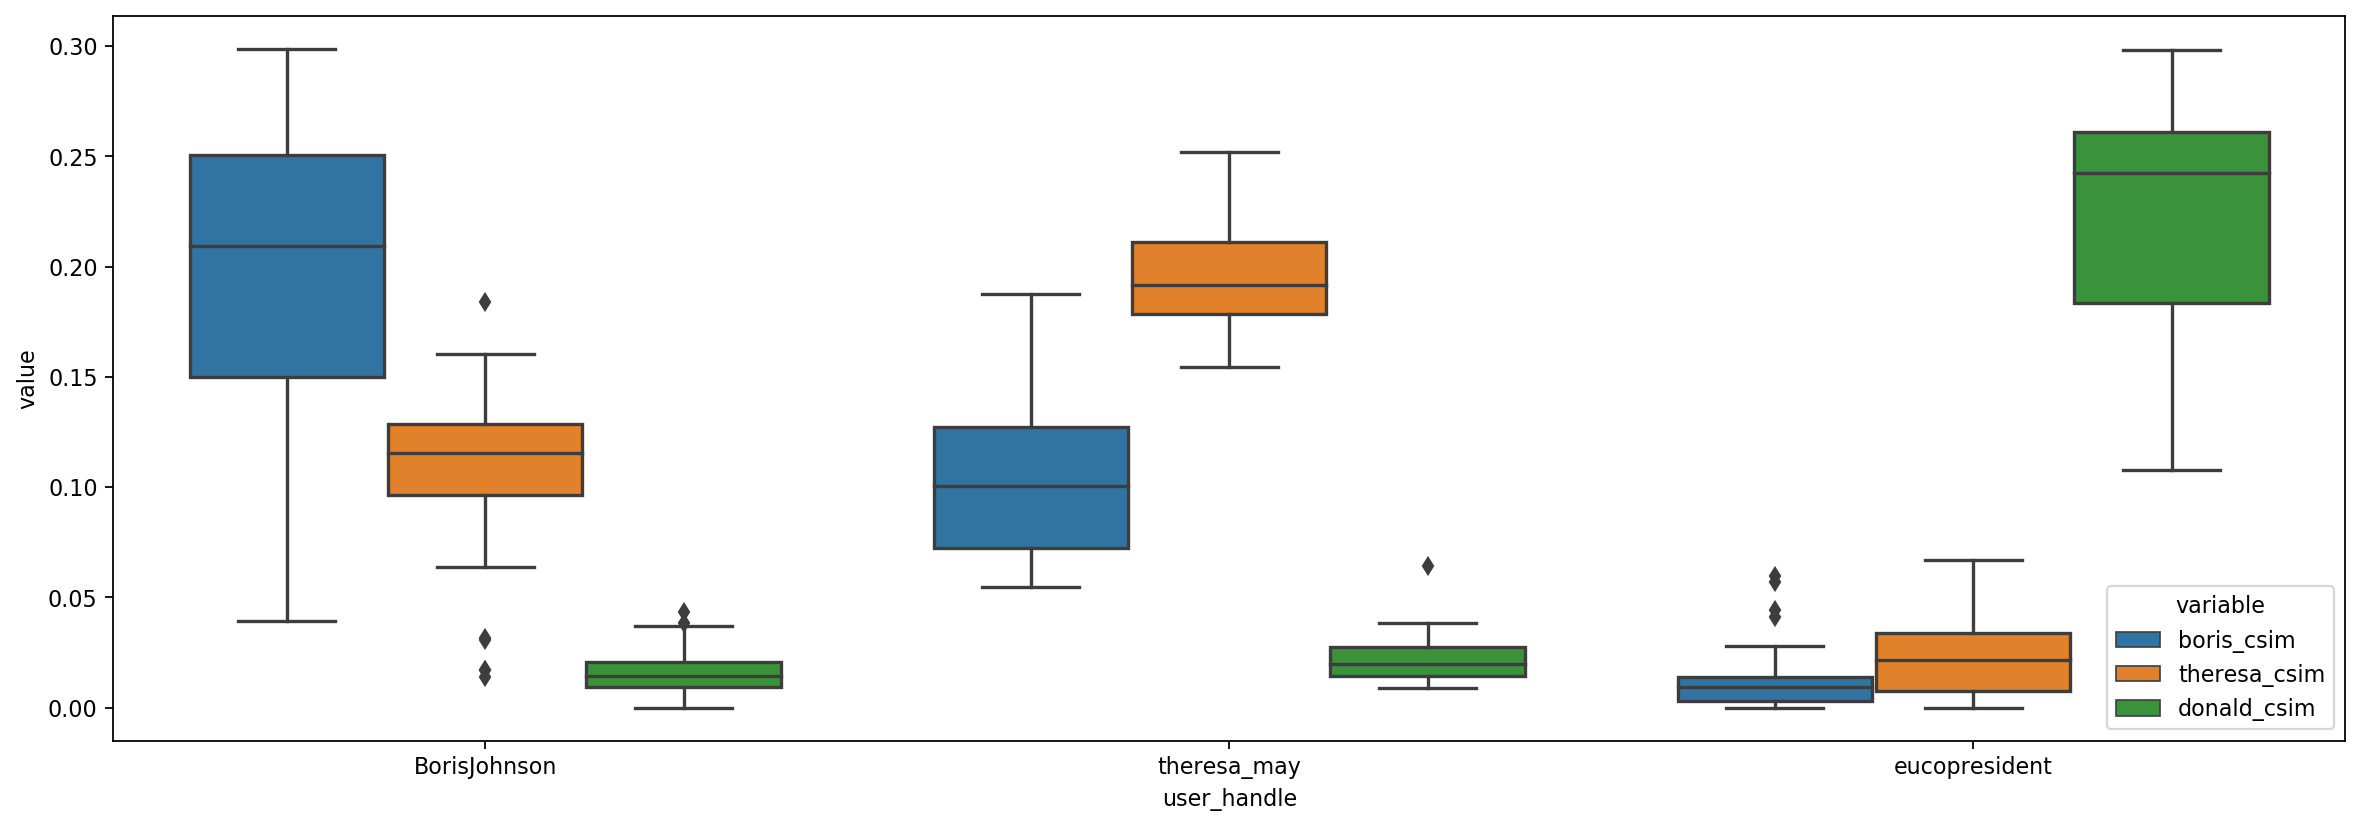

In [21]:
plt.figure(figsize=(18, 6), dpi= 160)
sns.boxplot(x="user_handle", y="value", hue='variable', data=mdf)
plt.show()

In [22]:
# (2) Homework Solutions (Week 5)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Exercise 05 (optimizing python efficiency and code structure)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# (1) Write a pre_process() function that takes a string as an input, 
# does the following pre-processing steps, and returns a string with 
# whitespace separated and processed tokens: 
# - Tokenizing (TweetTokenizer)
# - Lowercasing
# - Punctuation Removal
# - Number Removal
# - Stopword Removal
# - Stemming (PorterStemmer)
# - URL Removal

# We have been using functions from the very beginning. Functions like
# type() or np.mean() were created by python or other people and contain
# pre-defined code. The cool thing about a programming language like 
# python is that you can write your own functions if you repeatedly need
# to do a specific task (like pre-processing thousands of tweets). This 
# is how you do it:

def pre_process(input_argument):
    # Do something with input_argument
    output = input_argument + 2
    
    # And return the output 
    return(output)

# If we now run the pre_process() function we get what we told it to do.
pre_process(5)

7

In [23]:
# In our case, we want the function to take the original
# tweet text, apply all of our learned pre-processing
# techniques to it, and return the whitespace-separated
# string that we can input into a vectorizer. So, we can
# copy-paste a bunch of stuff from before:

# Load all dependencies 
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

import string
punct = string.punctuation
punct = punct + "’"

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

# Rather than writing a for-loop, however, we define a
# function.
def pre_process(tweet):
    # Turn string into list of tokens
    tokens = tokenizer.tokenize(tweet)
    
    # Lowercase every token
    tokens = [t.lower() for t in tokens]
    
    # Remove punctuation from token list
    tokens = [t for t in tokens if t not in punct]
    
    # Remove stopwords from token list
    tokens = [t for t in tokens if t not in stop_words]
    
    # Stem each token
    tokens = [stemmer.stem(t) for t in tokens]
    
    # URL removal
    tokens = [t for t in tokens if not "https://" in t]
    
    # Whitespace separate all tokens into one string
    tweet = " ".join(tokens)
    
    # And return the pre-processed tweet
    return(tweet)

# If we now run this function with a single tweet, we 
# should get the processed tweet as an output:
pre_process(df.loc[0, "tweet_text"])

'corbyn friend parliament trust make decis let put peopl delay corbyn #surrenderbil brexit deliv octob 31st'

In [1]:
# (2) Use it to recreate the 'processed' variable. I.e., loop through
# each row of the dataframe containing the tweets from Boris, Theresa,
# and Donald, process the respective 'tweet_text,' and save it in the
# 'processed' column.

# Let's reload the dataframe to make sure that everything works.
df = feather.read_dataframe("../data/love-triangle.feather")
df = df.loc[df['tweet_text'].notna(), ['user_handle', 'tweet_text']]
df = df.reset_index(drop=True)

# Now we are back to a for-loop, but we can write it much shorter.
for row in range(len(df)):
    df.loc[row, 'processed'] = pre_process(df.loc[row, 'tweet_text'])
df

NameError: name 'feather' is not defined

In [25]:
# (3) Extend the function to take two argument. First, the string of the
# text to be processed, then an argument 'stemming' that is set to True
# by default, but if set to False will skip the step of stemming inside 
# the function.

# This was only the start of your many adventure with functions. A crucial
# and often very useful extension of this basic approach is to make functions
# take more than one argument as an input. Whenever you look up functions from
# other packages, you might notice that there is usually more than one thing 
# you can tweek. Here's how you could use that to quickly see whether stemming
# makes a difference in your analysis.

def pre_process(tweet, stemming=True):
    # Turn string into list of tokens
    tokens = tokenizer.tokenize(tweet)
    
    # Lowercase every token
    tokens = [t.lower() for t in tokens]
    
    # Remove punctuation from token list
    tokens = [t for t in tokens if t not in punct]
    
    # Remove stopwords from token list
    tokens = [t for t in tokens if t not in stop_words]
    
    if stemming:
        # Stem each token
        tokens = [stemmer.stem(t) for t in tokens]
    
    # URL removal
    tokens = [t for t in tokens if not "https://" in t]
    
    # Whitespace separate all tokens into one string
    tweet = " ".join(tokens)
    
    # And return the pre-processed tweet
    return(tweet)

# Let's see what this does
print(pre_process(df.loc[0, 'tweet_text'])) # If you don't provide an argument, python will use the default you specified above
print(pre_process(df.loc[0, 'tweet_text'], stemming=True))
print(pre_process(df.loc[0, 'tweet_text'], stemming=False))

corbyn friend parliament trust make decis let put peopl delay corbyn #surrenderbil brexit deliv octob 31st
corbyn friend parliament trust make decis let put peopl delay corbyn #surrenderbil brexit deliv octob 31st
corbyn friends parliament trust make decision let put people delay corbyn #surrenderbill brexit delivered october 31st


In [26]:
# (4) Use the time() function from the time package to benchmark how quick
# your function performs with and without stemming.
# Tip: start = time.time() ; end = time.time() ; end-start; Look up
# the documentation of the time.time() function to understand what
# the output means.

# Optimizing your python code for speed is a never ending journey. Not least
# because a lot depends on your computer, your operating system, the kind
# of data you need, and which version of a package you use. All of these
# might impact how long your computer takes. It is useful to test your code
# on a smaller sample of data before running it over your entire dataset.
# First, you can make sure that everything works as you intended. Second, you
# can spot time-consuming faux-pas in your coding logic early on and safe
# time later on.

# So, let's use time.time() to clock our code
import time

# First, with stemming...
start = time.time()
pre_process(df.loc[0, "tweet_text"])
end = time.time()

print("With stemming, it took " + str(end-start) + " seconds")

# Now, without...
start = time.time()
pre_process(df.loc[0, "tweet_text"], stemming=False)
end = time.time()

print("Without stemming, it took " + str(end-start) + " seconds")


With stemming, it took 0.0010800361633300781 seconds
Without stemming, it took 0.0007526874542236328 seconds


In [27]:
# (5) Use the same approach to benchmark how quick the processing of the
# entire tweet texts in df takes when you apply your pre_process() function
# in a classical for-loop vs. list-comprehension.

# For loop...
start = time.time()
for row in range(len(df)):
    df.loc[row, "processed"] = pre_process(df.loc[row, "tweet_text"])
end = time.time()

print("A for-loop takes " + str(end-start) + " seconds to process everything")

# List comprehension
start = time.time()
df['processed'] = [pre_process(t) for t in df['tweet_text']]
end = time.time()

print("A list-comprehension takes " + str(end-start) + " seconds to process everything")

A for-loop takes 0.11359286308288574 seconds to process everything
A list-comprehension takes 0.056842803955078125 seconds to process everything


In [28]:
# (6) Use the multiprocessing package to try to optimize the speed further. 
# Time it and see how it stacks up against for-loops and list-comprehension.
# Tip: pool.map(function, ...)

# This one can be super useful if you manage to set it up properly. But it
# can also be super frustrating because a lot depends on your personal 
# computer. So, try this out, but if you get stuck, you do not have to do
# this step. Sometimes, it is easier to avoid multiprocessing and just
# let your computer run for a few hours while you read a book, watch Netflix,
# or go for a drink with friends ;-)

# That being said, here is the simplest way to write multiprocessing into
# your workflow.
from multiprocessing import Pool
from multiprocessing import cpu_count

# First, let's check how many CPU's your computer has to offer. You should 
# try to avoid using all of them at the same time because your computer
# might struggle to do the simplest task while your python code is running.
use_this_many = cpu_count() - 1
use_this_many

3

In [29]:
# The following initializes an instance of the class Pool(), from which
# we can use the .map() method to apply a function to every element in
# a list
start = time.time()
with Pool(processes=use_this_many) as pool:
    df['processed'] = pool.map(pre_process, [t for t in df['tweet_text']])
    
end = time.time()
print("Multiprocessing with two cores took " + str(end-start) + " seconds to process everything.")

Multiprocessing with two cores took 0.1441490650177002 seconds to process everything.


In [30]:
# (7) Process the JSON file "2019-12-06_16-43-32.json" to extract
# all the tweet texts and compare the time of for-loops, 
# list-comprehension, and parallel processing for a bigger dataset.
# (When processing the JSON file, you can simply focus on 
# tweet['text'] inthe Twitter object and ignore the ideosyncracies 
# of extended_status, retweets and quotes for now. We are interested 
# in processing speed.)

# Let's load the JSON file
import json
json_data = open("Data/2019-12-06_16-43-32.json").read()
json_data = json.loads(json_data)

# And define a function for extracting the tweet text. Doing so might
# seem over-the-top at times, but it makes it much easier to do a lot
# of stuff in a one-liner list-comprehension and is necessary if you
# want to use multiprocessing...
def extract_text(tweet):
    tweet = json.loads(tweet)
    text = tweet['text']
    return(text)

In [31]:
# Let's start with a for loop
start = time.time()
texts = []
for tweet in json_data:
    texts.append(extract_text(tweet))
end = time.time()
print("For loop takes " + str(end-start) + " seconds") 
del(texts)

For loop takes 2.569617986679077 seconds


In [32]:
# List comprehension
start = time.time()
texts = [extract_text(tweet) for tweet in json_data]
end = time.time()
print("List-comprehension takes " + str(end-start) + " seconds")
del(texts)

List-comprehension takes 2.581041097640991 seconds


In [33]:
# Multiprocessing
start = time.time()
with Pool(use_this_many) as pool:
    texts = pool.map(extract_text, [tweet for tweet in json_data])
    
end = time.time()
print("MP takes " + str(end-start) + " seconds")

MP takes 2.0195391178131104 seconds


In [34]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# (3) POS, lemmas, and word embeddings – how to get them with spacy
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# So far, we've used internal string functionalities from python and 
# additional NLP tools from NLTK. There are plenty of other packages
# that you might find useful in the future:
# NLTK
# Gensim
# polyglot
# TextBlob
# CoreNLP
# spaCy
# Flair
# ...

# We have focused on NLTK because it is super comprehensive and fairly
# easy to use. Meaning, it functions a bit like a hub to a lot of 
# established NLP pipelines for various tasks. Cool, and it gives you 
# a lot of control to do robustness checks with different stemmers,
# tokenizers, etc.

# For POS, lemmatizing and word embeddings, I think it is useful to know
# how to use spaCy too. It is probably the most easy to use NLP pipeline
# out there, and provides very high-quality tools. But it comes with some
# ideosyncracies, so use it carefully and always try to understand what
# it does to your data.

# The advantage of spaCy is it's outstanding documentation, so make use
# of it: https://spacy.io/usage/ 

# Use pip to install the base package in your command line tool
#pip install spacy

# Stay in the command line tool, and use the following to install all the
# things necessary to use spacy for POS tagging, lemmatizing AND get 
# pre-trained word vectors (700MB storage required)
#python -m spacy download en_core_web_lg

# In order to use this collection of NLP stuff, use the following to
# create a shortcut link "en_default" to that collection:
#python -m spacy link en_core_web_lg en_default

# Let's load all of that stuff into your current python session (might take a 
# few seconds)
import spacy
nlp = spacy.load("en_default")

In [35]:
# The nlp object is a all-in-one function with which you can process
# strings and get all the different NLP things for each token
doc = nlp(df.loc[0, "tweet_text"])
doc

Corbyn and his friends in Parliament don’t trust you to make this decision - but I do. Let’s put it to the people: more delay with Corbyn’s #SurrenderBill, or Brexit delivered on October 31st ???? https://t.co/q8tIwDMkcH

In [36]:
# Let's loop through each token and extract some stuff
for token in doc:
    print(token)
    print(token.lemma_)
    print(token.pos_)
    print("\n")

Corbyn
Corbyn
PROPN


and
and
CCONJ


his
-PRON-
DET


friends
friend
NOUN


in
in
ADP


Parliament
Parliament
PROPN


do
do
AUX


n’t
not
PART


trust
trust
VERB


you
-PRON-
PRON


to
to
PART


make
make
VERB


this
this
DET


decision
decision
NOUN


-
-
PUNCT


but
but
CCONJ


I
-PRON-
PRON


do
do
AUX


.
.
PUNCT


Let
let
VERB


’s
-PRON-
PRON


put
put
VERB


it
-PRON-
PRON


to
to
ADP


the
the
DET


people
people
NOUN


:
:
PUNCT


more
more
ADJ


delay
delay
NOUN


with
with
ADP


Corbyn
Corbyn
PROPN


’s
’s
PART


#
#
PROPN


SurrenderBill
SurrenderBill
PROPN


,
,
PUNCT


or
or
CCONJ


Brexit
Brexit
PROPN


delivered
deliver
VERB


on
on
ADP


October
October
PROPN


31st
31st
NOUN


?
?
PUNCT


?
?
PUNCT


?
?
PUNCT


?
?
PUNCT


https://t.co/q8tIwDMkcH
https://t.co/q8tiwdmkch
X




In [37]:
# With this, we can easily get the lemmas of each token...
lemmatized = [token.lemma_ for token in doc]
print(" ".join(lemmatized))

Corbyn and -PRON- friend in Parliament do not trust -PRON- to make this decision - but -PRON- do . let -PRON- put -PRON- to the people : more delay with Corbyn ’s # SurrenderBill , or Brexit deliver on October 31st ? ? ? ? https://t.co/q8tiwdmkch


In [38]:
# and filter out certain tokens that don't fulfil an important 
# grammatical function.
keep_these = ["PROPN", "NOUN", "VERB", "ADJ"]
pos_filtered = [token.lemma_ for token in doc if token.pos_ in keep_these]
print(" ".join(pos_filtered))

Corbyn friend Parliament trust make decision let put people more delay Corbyn # SurrenderBill Brexit deliver October 31st


In [39]:
# Note that this requires us to trust spacy's internal tokenization 
# approach because it is an internally coherent ecosystem. One way to
# keep hashtags intact might therefore be to replace the hashtag sign
# with something else before you run it through spacy: 
# "#SurrenderBill" could become "hashtag_SurrenderBill"
test = df.loc[0, 'tweet_text']
test = test.replace("#SurrenderBill", "hashtag_SurrenderBill")
test = " ".join([token.lemma_ for token in nlp(test) if token.pos_ in keep_these])
print(test)

Corbyn friend Parliament trust make decision let put people more delay Corbyn ’s hashtag_SurrenderBill Brexit deliver October 31st


In [40]:
# After using spacy, we could restore this to the original if needed
test = test.replace("hashtag_SurrenderBill", "#SurrenderBill")
print(test)

# You could use regular expressions to recognize tokens that start with a
# hashtag, and systematically replace this before and after you use spacy.

Corbyn friend Parliament trust make decision let put people more delay Corbyn ’s #SurrenderBill Brexit deliver October 31st


In [41]:
# The more interesting reason to use spaCy, however, is that it comes
# with a very extensive set of pre-trained word embeddings that you
# could use out of the box to try out whether the semantic information
# encoded into these vectors might be useful for the task you have in
# mind. While training your own word vectors is a challenging task, and
# while interpreting these for analysis is still a bit of Voodoo, turning
# tokens into pre-trained vectors has become quite easy with spacy:

# You can get averaged document vectors after you ran your text through
# spacy's nlp().
doc = nlp(df.loc[0, 'tweet_text'])
tweet_vec = doc.vector
tweet_vec

array([-3.61733697e-02,  1.93291649e-01, -1.14510722e-01, -8.47847480e-03,
        5.09004854e-03, -3.53527963e-02,  5.64846434e-02, -1.36466414e-01,
       -1.75531749e-02,  1.95582962e+00, -2.77072191e-01,  2.73497049e-02,
        7.21303076e-02, -3.52422409e-02, -1.84240714e-01, -2.12711953e-02,
       -8.72768909e-02,  8.92767012e-01, -1.30336970e-01,  2.29953299e-03,
        5.68336099e-02,  3.77866589e-02, -6.65359851e-03, -6.49593547e-02,
        3.10096727e-03,  8.47741589e-03, -4.88848314e-02, -2.51352768e-02,
        6.62064776e-02, -1.07002765e-01, -4.97501530e-02,  9.97915789e-02,
       -6.98460862e-02,  1.32673904e-02,  8.59847963e-02,  4.30989778e-03,
        7.39070103e-02,  6.79225102e-02, -2.69372016e-02, -4.66955230e-02,
       -2.69884206e-02, -8.17632675e-03, -2.20535658e-02, -4.00256217e-02,
        4.95304130e-02,  7.69707710e-02, -1.32202372e-01,  2.16195732e-02,
       -3.76631133e-02,  2.60413215e-02, -1.94404572e-02,  6.80862367e-02,
        1.11749368e-02, -

In [42]:
# You can get each word vector by doing the same for each token
# in the doc. You can turn it into a multidimensional numpy array
# for easier manipulation later on.
word_vecs = np.array([token.vector for token in doc])
word_vecs

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [-0.18567 ,  0.066008, -0.25209 , ..., -0.023452,  0.12302 ,
         0.3312  ],
       [ 0.019097,  0.23119 , -0.1681  , ...,  0.52329 ,  0.14751 ,
        -0.16854 ],
       ...,
       [-0.086864,  0.19161 ,  0.10915 , ..., -0.01516 ,  0.11108 ,
         0.2065  ],
       [-0.086864,  0.19161 ,  0.10915 , ..., -0.01516 ,  0.11108 ,
         0.2065  ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

In [43]:
# If you want, you could recreate the tweet_vec by averaging all
# of these word vectors into a single 300-dimensional vector.
tweet_vec == np.mean(word_vecs, axis=0)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [44]:
# Let's get a tweet from Boris, Theresa, and Donald to compare their 
# document vectors
df_small = df.loc[[0, 2, 3], ]
df_small = df_small.reset_index(drop=True)
df_small

,user_handle,tweet_text,processed
0,BorisJohnson,Corbyn and his friends in Parliament don’t tru...,corbyn friend parliament trust make decis let ...
1,theresa_may,You want this stage of the Brexit process to b...,want stage brexit process done agre side
2,eucopresident,EU27 unanimously agrees on its response to UK’...,eu27 unanim agre respons uk request meet pm @t...


In [45]:
# For each text, apply the nlp() function, and then get the 
# 300-dimensional document vector and stack it onto a 
# multidimensional np.array
vec_compare = [nlp(tweet) for tweet in df_small['tweet_text']]
vec_compare = [doc.vector for doc in vec_compare]
vec_compare

[array([-3.61733697e-02,  1.93291649e-01, -1.14510722e-01, -8.47847480e-03,
         5.09004854e-03, -3.53527963e-02,  5.64846434e-02, -1.36466414e-01,
        -1.75531749e-02,  1.95582962e+00, -2.77072191e-01,  2.73497049e-02,
         7.21303076e-02, -3.52422409e-02, -1.84240714e-01, -2.12711953e-02,
        -8.72768909e-02,  8.92767012e-01, -1.30336970e-01,  2.29953299e-03,
         5.68336099e-02,  3.77866589e-02, -6.65359851e-03, -6.49593547e-02,
         3.10096727e-03,  8.47741589e-03, -4.88848314e-02, -2.51352768e-02,
         6.62064776e-02, -1.07002765e-01, -4.97501530e-02,  9.97915789e-02,
        -6.98460862e-02,  1.32673904e-02,  8.59847963e-02,  4.30989778e-03,
         7.39070103e-02,  6.79225102e-02, -2.69372016e-02, -4.66955230e-02,
        -2.69884206e-02, -8.17632675e-03, -2.20535658e-02, -4.00256217e-02,
         4.95304130e-02,  7.69707710e-02, -1.32202372e-01,  2.16195732e-02,
        -3.76631133e-02,  2.60413215e-02, -1.94404572e-02,  6.80862367e-02,
         1.1

(3.0, 0.0)

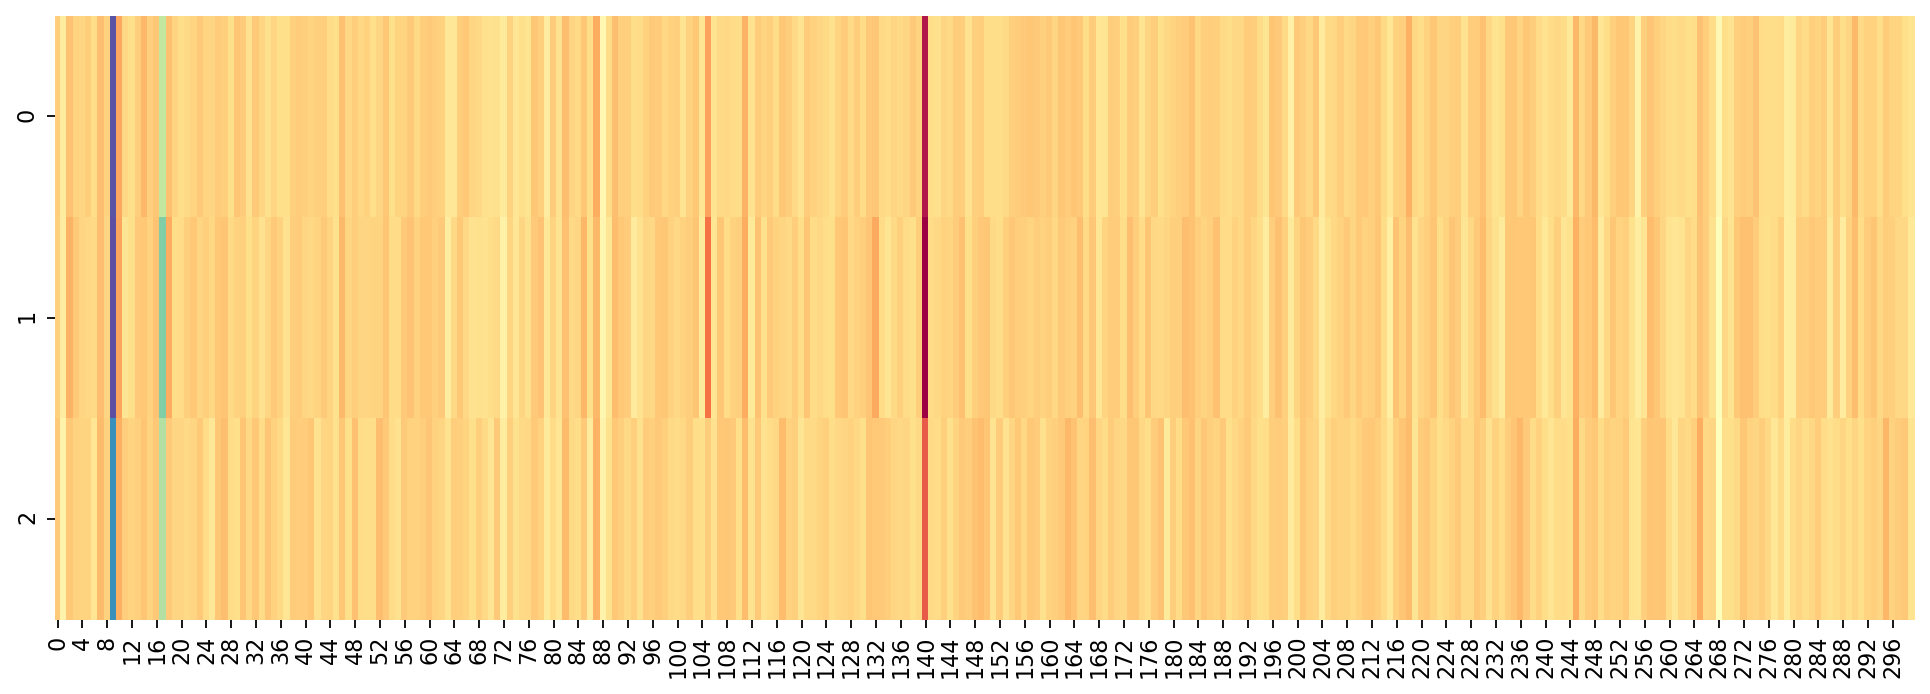

In [46]:
# Small visualization tip: heatmaps don't necessarily enable you
# to understand the differences in these highly complex vectors, but
# they might give you a better sense of what you are dealing with.

# We can make fairly nice heatmaps with the matplotlib and seaborn
# packages. Again, for publication ready graph, resort to ggplot in R.
import matplotlib.pylab as plt
import seaborn as sns

# The following sets some depiction options to ensure that the jupyter
# notebook output is filling the entire space and producing a high-resolution
# image. Play with the values to make it work for your specific computer 
# screen and browser.
plt.figure(figsize=(15, 5), dpi= 160)

# The following rather complex code is necessary because there are some
# version issues with seaborn and matplotlib lately...
hmap = sns.heatmap(vec_compare, cmap="Spectral", cbar=False)
bottom, top = hmap.get_ylim()
hmap.set_ylim(bottom + 0.5, top - 0.5)

In [47]:
# A more systematic comparison would be to use cosine_similarity again.
cosine_similarity(vec_compare)

array([[0.9999999 , 0.94226134, 0.8862407 ],
       [0.94226134, 0.9999999 , 0.8737196 ],
       [0.8862407 , 0.8737196 , 1.0000001 ]], dtype=float32)

In [48]:
# Let's recreat the famous kind-man+woman=queen example
doc = nlp("king man woman queen")

word_vecs = np.array([token.vector for token in doc])
word_vecs

array([[ 0.31542 , -0.35068 ,  0.42923 , ...,  0.11427 ,  0.58221 ,
        -0.10559 ],
       [-0.1731  ,  0.20663 ,  0.016543, ...,  0.16665 , -0.38341 ,
        -0.073803],
       [ 0.025567,  0.27885 , -0.16992 , ..., -0.018582, -0.10128 ,
        -0.34728 ],
       [ 0.4095  , -0.22693 ,  0.25362 , ..., -0.34563 ,  0.12043 ,
        -0.36494 ]], dtype=float32)

In [49]:
# As praised in every article about word vectors, you can do all
# kinds of math stuff with these vectors. To get something semantically
# closer to queen, let's substract man [1] from king [0] and add woman [2]
queen_clone = word_vecs[0] - word_vecs[1] + word_vecs[2]
queen_clone

array([ 5.14087021e-01, -2.78459996e-01,  2.42767006e-01,  4.54899669e-02,
       -2.59425014e-01, -3.19999963e-01,  3.23920012e-01, -6.71030045e-01,
       -9.98499990e-02,  1.91499996e+00, -5.68080008e-01, -2.74451017e-01,
       -1.49906695e-01,  8.01083148e-02, -2.34764010e-01, -1.10950008e-01,
       -1.02593988e-01,  8.53819966e-01, -2.68564999e-01,  3.85140002e-01,
       -1.36149988e-01,  6.35029972e-01, -7.62044966e-01, -2.52770007e-01,
       -6.75969958e-01,  3.89851004e-01, -2.89680034e-01,  1.75860003e-01,
       -5.16229987e-01,  5.21373034e-01, -1.89909995e-01,  6.73759937e-01,
        1.17550008e-01, -4.69896019e-01,  5.88999987e-01,  1.29447982e-01,
       -5.71900010e-01, -5.47450066e-01, -4.84210014e-01,  5.85503951e-02,
        4.82379973e-01, -2.86769986e-01, -2.01718003e-01, -4.74729985e-01,
        3.43068987e-01, -2.28827983e-01, -1.76439017e-01,  6.05450034e-01,
        2.07139999e-01, -2.89762974e-01, -7.63288975e-01,  4.37090009e-01,
       -2.06220001e-01, -

In [50]:
# So, we got a bit closer...
print("King to Queen Similarity: " + str(cosine_similarity([word_vecs[0]], [word_vecs[3]])[0][0]))
print("Queen_Clone to Queen Similarity: " + str(cosine_similarity([queen_clone], [word_vecs[3]])[0][0]))

King to Queen Similarity: 0.725261
Queen_Clone to Queen Similarity: 0.7880845


In [51]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Exercise 06
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# (1) Recreate the df_joint dataframe with 3 rows containing the 
# collected tweets from Boris, Theresa, and Donald.

# (2) Use spacy to pre-process each tweet collection: Get the lemmas
# and keep only nouns, adjectives, advers, and verbs. Use the spacy
# documentation to find out which tags to use.

# (3) Turn the pre-processed documents into a document term matrix
# with the CountVectorizer and use this to compare the cosine 
# similarity between Boris, Theresa, and Donald's Brexit tweets.

# (4) Take the five tweets from the slides and turn them into word
# vectors with spacy (list of lists). Here are the texts...
tweets = ["""#Brexit means that we gain back sovereignty and that the UK will free itself from the detached Brussels elite. Boris will make Britain great again!!!""",
         """Brexit means Brexit! The EU should stop their bullshit and accept the new reality #MakeBritainGreatAgain""",
         """Brexit just means that we’ll have to wait in longer cues at passport control. So much for #MakeBritainGreatAgain... “Great” Britain my ass...""",
         """How are we gaining back sovereignty with Brexit?!? This is the greatest bullshit I’ve heard in a long time. I mean, Boris is completely detached from reality.""",
         """”Brexit means Brexit” – what does that even mean?!?!"""]

# (5) Let's try to recreate the dimensions projection from the Kozlowski
# article. Create a new vector called leave_remain that averages the 
# difference between the vectors from the tweets above. Use np.mean()
# over a list of all the possible combinations of leave - remain tweets
# you can find. 
# Tip: Use the axis argument of np.mean() to make sure that you retain the
# 300-dimensional shape of the vectors.

# (6) Use cosine_similarity to see how each of these tweets is placed on
# this newly created leave-remain dimension.

# (7) Use cosine_similarity to see whether this leave-remain dimension is
# sufficiently valid to place the collected tweets of Boris, Theresa, and
# Donald on the right place of this axis.
# Tip: It isn't. But the exercise is useful to see how such a dimension
# projection would be implemented in python ;-)